# GloFAS - extract time series
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 06-05-2025<br>

**Introduction:**<br>
This code takes as input the NetCDF files of simulated reservoir filling ($rsfil$) from the GloFASv4 long run and extracts the time series for the pixels corresponding to reservoirs included both in ResOpsUS and GloFAS.

**To do:**<br>
* [ ] Replace the last cell (the one that extracts the point time series) by the `lisfloodutilities.ncextract` tool.

<font color='red'>Not necessary any more. This extraction could be done simply running the utility `ncextract` on the _rsfil_ results. Besides, the time series of _rsfil_ are not necessary in the final dataset.</font>

In [23]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
from tqdm.auto import tqdm
import yaml
from typing import Optional, Union

import warnings
warnings.filterwarnings('ignore')

In [2]:
from lisfloodreservoirs.ncextract import extract_timeseries

In [25]:
# def extract_timeseries(maps: xr.Dataset,
#                        poi: xr.Dataset,
#                        outputfile: Optional[Union[str, Path]] = None
#                       ) -> Optional[xr.Dataset]:
#     """It extract from a series of input files (NetCDF or GRIB) the time series of a set of points

#     Parameters:
#     -----------
#     maps: xarray.Dataset
#         the time stack of input maps from which the time series will be extracted
#     poi: xarray.Dataset
#         a Dataset indicating the coordinates of the points of interest. It must have only two variables (the coordinates), and the names of this variables must be dimensions in "maps"
#     ouputfile: optional, string or pathlib.Path
#         the file where the results will be saved. It can be either a CSV or a NetCDF file

#     Returns:
#     --------
#     By default, it puts out an xarray.Dataset with the extracted time series. Instead, if "outputfile" is provided, results will be saved to a file (CSV or NetCDF)
#     """

#     coord_1, coord_2 = list(poi)
#     if not all(coord in maps.coords for coord in [coord_1, coord_2]):
#         print(f'ERROR: The variables in "poi" (coordinates) are not coordinates in "maps"')
#         sys.exit(1)

#     # extract time series
#     maps_poi = maps.sel({coord_1: poi[coord_1], coord_2: poi[coord_2]}, method='nearest')

#     if outputfile is None:
#         return maps_poi.compute()

#     else:
#         outputfile = Path(outputfile)
#         if outputfile.suffix == '.nc':
#             maps_poi.to_netcdf(outputfile)
#         elif outputfile.suffix == '.csv':
#             df = maps_poi.to_dataframe()
#             df_reset = df.reset_index()
#             df_reset.to_csv(outputfile, index=False)
#         else:
#             print('ERROR: the extension of the output file must be either ".nc" or ".csv"')
#             sys.exit(2)
#         print(f'Results exported as {outputfile}')

## Configuration

In [15]:
with open('config_extraction.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# paths
PATH_GLOFAS = Path(cfg['paths']['GloFAS'])
PATH_RESOPS = Path(cfg['paths']['ResOpsUS'])

# extraction
PATH_TS = Path(cfg['extraction']['path_in'])
VAR = cfg['extraction']['variable']
if len(VAR) == 1:
    VAR = VAR[0]
PATH_OUT = Path(cfg['extraction']['path_out']) / VAR
PATH_OUT.mkdir(parents=True, exist_ok=True)
print('Results will be saved in the directory:', PATH_OUT)

## Data

### ResOpsUS

ResOpsUS contains 677 reservoirs


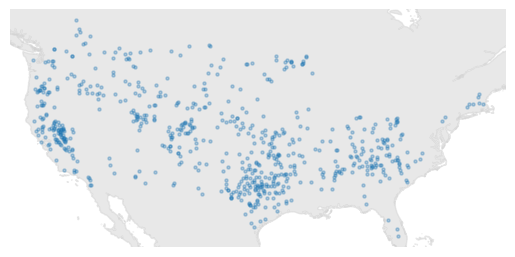

In [7]:
# import shapefile
resops = gpd.read_file(PATH_RESOPS / 'raw' / 'GIS' / 'reservoirs.shp')
resops.set_index('DAM_ID', drop=True, inplace=True)
print(f'ResOpsUS contains {resops.shape[0]} reservoirs')

# plot reservoir locations
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
ax.scatter(resops.geometry.x, resops.geometry.y, s=5, alpha=.3)
ax.set_aspect('equal')
ax.axis('off');

### GloFAS
#### Shapefile

GloFAS contains 121 reservoirs matching those in ResOpsUS


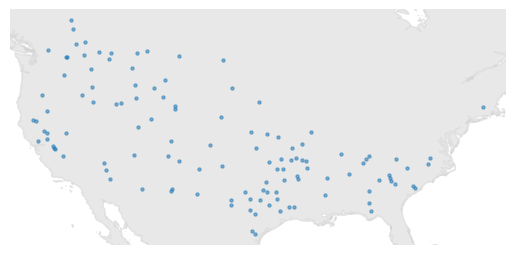

In [8]:
# load GloFAS reservoirs
glofas_shp = gpd.read_file(PATH_GLOFAS / 'tables' / 'GloFAS_reservoirs.shp')
glofas_shp.GRAND_ID = glofas_shp.GRAND_ID.astype(pd.Int64Dtype())
glofas_shp.GLWD_ID = glofas_shp.GLWD_ID.astype(pd.Int64Dtype())
glofas_shp.set_index('GRAND_ID', inplace=True)

# keep only reservoirs in ResOpsUS
mask = glofas_shp.index.intersection(resops.index)
glofas_shp = glofas_shp.loc[mask]

# remove duplicates
glofas_shp = glofas_shp[~glofas_shp.index.duplicated(keep='first')]
glofas_shp.sort_index(axis=0, inplace=True)

# plot reservoir locations
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
ax.scatter(glofas_shp.geometry.x, glofas_shp.geometry.y, s=5, alpha=.5)
ax.set_aspect('equal')
ax.axis('off');
print(f'GloFAS contains {glofas_shp.shape[0]} reservoirs matching those in ResOpsUS')

In [18]:
# export
glofas_shp.to_file(PATH_OUT / 'reservoirs.shp')

#### Raster

  0%|          | 0/121 [00:00<?, ?it/s]

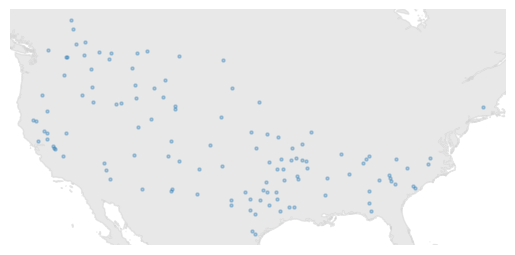

In [19]:
# load static map of reservoirs
file = list((PATH_GLOFAS / 'static_maps').glob('*_reservoirs_*.nc'))[0]
glofas_raster = xr.open_dataset(file)['res']

# extract an array of reservoir ID
# ids = np.unique(glofas_raster.where(~glofas_raster.isnull(), drop=True))
# ids = ids[~np.isnan(ids) & (ids != -9999)]
# ids = ids.astype(int)
ids = glofas_shp.ResID.sort_values().values

# xr.DataArrays of reservoir longitudes and latitudes
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
for id in tqdm(ids):
    cell = glofas_raster.where(glofas_raster == id, drop=True)
    lon.loc[dict(ResID=id)] = cell.lon.data[0]
    lat.loc[dict(ResID=id)] = cell.lat.data[0]
coords = xr.Dataset({'lon': lon, 'lat': lat})

# plot reservoir locations
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
ax.scatter(lon.data, lat.data, s=5, alpha=.3)
ax.set_aspect('equal')
ax.axis('off');

In [43]:
# export csv to apply `lisfloodutilities.ncextract`
poi = pd.concat((lon.to_pandas(), lat.to_pandas()), axis=1)
poi.index.name = 'ID'
poi.columns = ['lon', 'lat']
poi.to_csv(PATH_OUT / 'reservoirs.csv', float_format='%.3f')

### Time series of reservoir storage

In [29]:
for file in tqdm(list((PATH_TS / VAR).glob(f'{VAR}_*.nc'))):
    
    # check if the data was already processed
    fileout = PATH_OUT / file.name
    if fileout.exists():
        continue
        
    # load NetCDF file
    da = xr.open_dataset(file, chunks={'time': 1})[var]

    # extract time series for each ID
    da_extract = xr.DataArray(dims=['time', 'ResID'], coords={'time': da.time, 'ResID': ids}, name=var, attrs=da.attrs)
    for id in tqdm(ids):
        lon, lat = coords.sel(ResID=id)['lon'].data, coords.sel(ResID=id)['lat'].data
        da_extract.loc[{'ResID': id}] = da.sel(lon=lon, lat=lat, method='nearest').drop(['lon', 'lat'])
    
    # export extraction
    da_extract.to_netcdf(fileout)

  0%|          | 0/39 [00:00<?, ?it/s]